# K Nearest Neighbour

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from Utils import plot_mi_heatmap, plotMetricsGraphComparison
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance

## Import Train and Test Datasets

These datasets have already gone through undersampling.

In [3]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
Y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
Y_test = pd.read_csv("Data/y_test.csv")

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [4]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Classification Model": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [5]:
train_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Baseline Model before Feature Engineering

In [6]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [7]:
knn_basic = KNeighborsClassifier().fit(X_train_basic, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_basic = knn_basic.predict(X_train_basic)
Y_test_pred_basic = knn_basic.predict(X_test_basic)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Before Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8914280109846999
Precision 	: 0.8892139652818413
Recall 		: 0.8942722636327972
F1 Score 	: 0.8917359413202934

**Test Set Metrics**
Accuracy 	: 0.7831457925636007
Precision 	: 0.4718266253869969
Recall 		: 0.4530321046373365
F1 Score 	: 0.462238398544131


## Baseline Model after Feature Engineering

In [8]:
knn = KNeighborsClassifier().fit(X_train, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_engineered = knn.predict(X_train)
Y_test_pred_engineered = knn.predict(X_test)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_engineered, Y_test, Y_test_pred_engineered, "After Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8878481757551981
Precision 	: 0.8928181186053442
Recall 		: 0.8815221655551196
F1 Score 	: 0.8871341854611854

**Test Set Metrics**
Accuracy 	: 0.7737279843444227
Precision 	: 0.4582089552238806
Recall 		: 0.5475624256837098
F1 Score 	: 0.4989165763813651


From the results, we observe that the model after feature engineering has a lower accuracy and precision score. This could be due to the curse of dimensionality as adding more features can lead to an increase in the dimensionality of the feature space. In KNN, as the dimensionality increases, the distance between data points becomes less meaningful, leading to a degradation in performance. 

Nevertheless, we will proceed with the engineered dataset for further analysis as our next step involves feature selection, where we aim to mitigate the curse of dimensionality by reducing the dimensionality of the feature space.

## Feature Selection for KNN

We are applying multiple techniques for KNN feature selection:
1. Eliminate the Features with zero permutation_importance
2. Forward Feature Selection
3. Backward Feature Elimination
4. Univariate Feature Selection

## Eliminate the Features with permutation_importance=0

This step aims to remove features that do not contribute to the model's ability to capture meaningful patterns in the data.

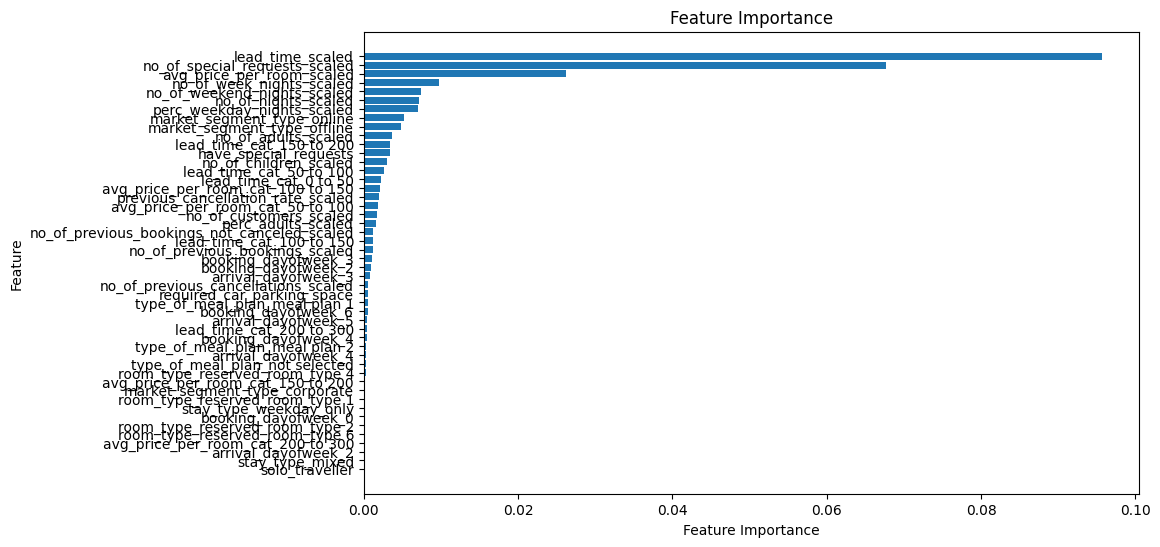

In [9]:
feature_importances, feature_names = compute_permutation_importance(knn, X_train, Y_train)

# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [10]:
selected_columns = feature_names

In [11]:
num_columns = X_train[selected_columns].shape[1]
print("Number of selected features:", num_columns)

Number of selected features: 48


### Fit the model again with the newly selected features

In [12]:
knn_selected = KNeighborsClassifier().fit(X_train[selected_columns], Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_selected = knn_selected.predict(X_train[selected_columns])
Y_test_pred_selected = knn_selected.predict(X_test[selected_columns])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Eliminate 0 Permutation Impt", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8899078069831307
Precision 	: 0.8905589940072699
Recall 		: 0.8890741467242056
F1 Score 	: 0.8898159509202453

**Test Set Metrics**
Accuracy 	: 0.7772749510763209
Precision 	: 0.46366962885520124
Recall 		: 0.5273483947681332
F1 Score 	: 0.4934631432545202


This step allows us to reduce the dimensionality of the feature space, enhancing computational efficiency and potentially mitigating overfitting concerns, while maintaining model performance.

Next, we try to perform a few feature selection methods to choose the best method that would give us the best model performance.

## 1. Forward selection using SequentialFeatureSelector from sklearn

In [13]:
# Initialize a KNN classifier
knn = KNeighborsClassifier()

# Initialize SequentialFeatureSelector with scoring='f1'
sfs_forward = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='forward', scoring='f1', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs_forward.fit(X_train[selected_columns], Y_train.values.ravel())

# Get the selected features
selected_features_forward = X_train[selected_columns].columns[sfs_forward.get_support()]

# Train the final model using the selected features on the training set
knn_forward = knn.fit(X_train[selected_features_forward], Y_train.values.ravel())

# Predict the output based on the training and testing datasets
Y_train_pred_forward = knn_forward.predict(X_train[selected_features_forward])
Y_test_pred_forward = knn_forward.predict(X_test[selected_features_forward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_forward, Y_test, Y_test_pred_forward, "Forward Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8947626520204002
Precision 	: 0.9079667545104398
Recall 		: 0.8785798352295018
F1 Score 	: 0.8930316020336956

**Test Set Metrics**
Accuracy 	: 0.7879158512720157
Precision 	: 0.48500576701268744
Recall 		: 0.5
F1 Score 	: 0.4923887587822014


## 2. Backward elimination using SequentialFeatureSelector from sklearn

In [14]:
# Initialize a KNN classifier
knn = KNeighborsClassifier()

# Initialize SequentialFeatureSelector with scoring='f1'
sfs_backward = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='backward', scoring='f1', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs_backward.fit(X_train[selected_columns], Y_train.values.ravel())

# Get the selected features
selected_features_backward = X_train[selected_columns].columns[sfs_backward.get_support()]

# Train the final model using the selected features on the training set
knn_backward = knn.fit(X_train[selected_features_backward], Y_train.values.ravel())

# Predict the output based on the training and testing datasets
Y_train_pred_backward = knn_backward.predict(X_train[selected_features_backward])
Y_test_pred_backward = knn_backward.predict(X_test[selected_features_backward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_backward, Y_test, Y_test_pred_backward, "Backward Feature Elimination", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8953020792467634
Precision 	: 0.9017243097777334
Recall 		: 0.8873087485288348
F1 Score 	: 0.8944584507390381

**Test Set Metrics**
Accuracy 	: 0.7800880626223092
Precision 	: 0.46864864864864864
Recall 		: 0.5154577883472057
F1 Score 	: 0.4909399773499434


## 3. Univariate Feature Selection

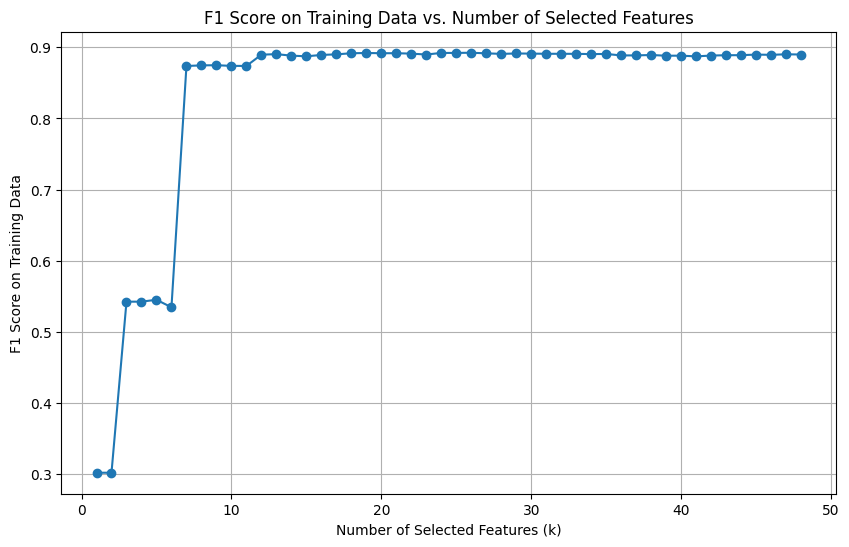

In [15]:
# Initialize KNN classifier
knn = KNeighborsClassifier()

# Initialize SelectKBest with f_classif scoring function
selector = SelectKBest(score_func=f_classif)

# Lists to store F1 scores and number of selected features
train_f1_scores = []
num_features_selected = []

# Iterate over different values of k
for k in range(1, X_train[selected_columns].shape[1] + 1):
    # Fit selector to training data with k features
    selector.set_params(k=k)
    X_train_selected = selector.fit_transform(X_train[selected_columns], Y_train.values.ravel())
    
    # Train LR classifier on selected features
    knn.fit(X_train_selected, Y_train.values.ravel())
    
    # Make predictions on the training data
    Y_train_pred = knn.predict(X_train_selected)
    
    # Calculate F1 score on the training data
    train_f1 = f1_score(Y_train, Y_train_pred)
    
    # Append F1 score and number of selected features to lists
    train_f1_scores.append(train_f1)
    num_features_selected.append(k)

# Plot F1 score vs. number of selected features
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, train_f1_scores, marker='o')
plt.title('F1 Score on Training Data vs. Number of Selected Features')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('F1 Score on Training Data')
plt.grid(True)
plt.show()

From the above graph, we can observe that as the number of selected features (k) increases beyond 12, the F1 score does not significantly increase further. Hence, to prioritize reduction of the dimensionality of the feature space and model complexity, we choose 12 as the number of features to be selected and set k=12.

In [16]:
# Select the best features 
selector_12 = SelectKBest(f_classif, k= 12) 
selector_12.fit(X_train[selected_columns], Y_train.values.ravel()) 
X_train_selected_ufs = selector_12.transform(X_train[selected_columns]) 
X_test_selected_ufs = selector_12.transform(X_test[selected_columns]) 

In [17]:
features_ufs_indices = selector_12.get_support(indices=True)
features_ufs = X_train.columns[features_ufs_indices]
features_ufs

Index(['traveller_type_adults_only', 'cancellation_type_mixed',
       'lead_time_cat_greater than 300', 'booking_dayofweek_0',
       'booking_dayofweek_2', 'booking_dayofweek_3', 'booking_dayofweek_6',
       'solo_traveller', 'booking_isweekend', 'perc_weekday_nights_scaled',
       'no_of_previous_bookings_scaled', 'previous_cancellation_rate_scaled'],
      dtype='object')

In [18]:
knn_ufs = KNeighborsClassifier().fit(X_train_selected_ufs,Y_train.values.ravel())

# Make predictions on the testing data
Y_train_pred_selected_ufs = knn_ufs.predict(X_train_selected_ufs)
Y_test_pred_selected_ufs = knn_ufs.predict(X_test_selected_ufs)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_ufs, Y_test, Y_test_pred_selected_ufs, "Univariate Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8917712828560219
Precision 	: 0.9078933932400695
Recall 		: 0.8720086308356219
F1 Score 	: 0.8895892741007554

**Test Set Metrics**
Accuracy 	: 0.7802103718199609
Precision 	: 0.4670864338866629
Recall 		: 0.48513674197384066
F1 Score 	: 0.4759405074365704


In [19]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Before Feature Engineering,0.783146,0.471827,0.453032,0.462238
1,After Feature Engineering,0.773728,0.458209,0.547562,0.498917
2,Eliminate 0 Permutation Impt,0.777275,0.463670,0.527348,0.493463
3,Forward Feature Selection,0.787916,0.485006,0.500000,0.492389
4,Backward Feature Elimination,0.780088,0.468649,0.515458,0.490940
5,Univariate Feature Selection,0.780210,0.467086,0.485137,0.475941


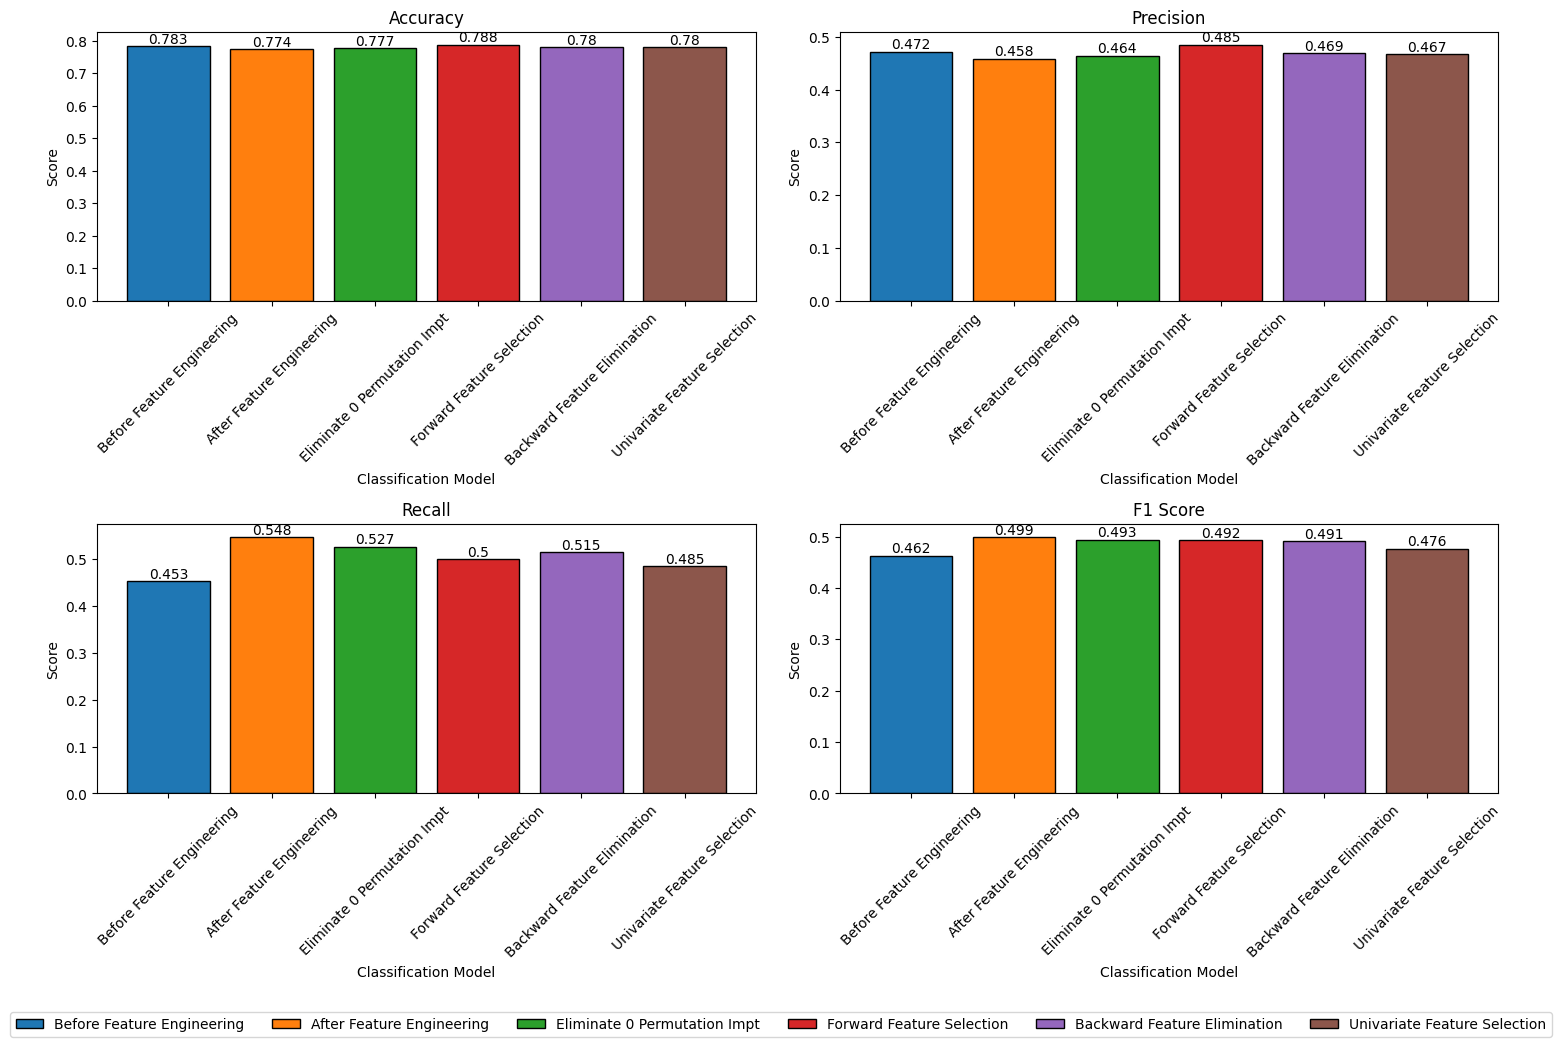

In [20]:
plotMetricsGraphComparison(test_metrics)

Comparing the results of the 4 feature selection methods, we observe that the forward selection method improved the model performance generally. 

Let us now take a look at the details of the selected features.

In [21]:
num_features = len(selected_features_forward)
print("Number of selected features:", num_features)

Number of selected features: 24


In [22]:
print("Selected Features:", selected_features_forward)

Selected Features: Index(['solo_traveller', 'avg_price_per_room_cat_200 to 300',
       'room_type_reserved_room_type 6', 'room_type_reserved_room_type 1',
       'market_segment_type_corporate', 'avg_price_per_room_cat_150 to 200',
       'room_type_reserved_room_type 4', 'type_of_meal_plan_meal plan 1',
       'required_car_parking_space', 'no_of_previous_cancellations_scaled',
       'no_of_previous_bookings_scaled', 'lead_time_cat_100 to 150',
       'no_of_previous_bookings_not_canceled_scaled', 'perc_adults_scaled',
       'avg_price_per_room_cat_50 to 100', 'previous_cancellation_rate_scaled',
       'avg_price_per_room_cat_100 to 150', 'have_special_requests',
       'lead_time_cat_150 to 200', 'market_segment_type_offline',
       'market_segment_type_online', 'avg_price_per_room_scaled',
       'no_of_special_requests_scaled', 'lead_time_scaled'],
      dtype='object')


## Hyperparameter Tuning

Hyperparameter tuning for a KNN (K-Nearest Neighbors) model involves selecting the optimal value for the n_neighbors parameter, which determines the number of neighbors to consider when making predictions. Here, we use Grid Search with cross-validation. 

In [23]:
parameter = {'n_neighbors': np.arange(2, 50, 1)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=parameter, cv=5, scoring='f1', verbose=2, n_jobs=-1)
knn_cv.fit(X_train[selected_features_forward], Y_train.values.ravel())
print(knn_cv.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'n_neighbors': 5}


Using the best parameter above to train the KNN model and calculate the evaluation metrics.

In [24]:
knn=KNeighborsClassifier(n_neighbors=5).fit(X_train[selected_features_forward], Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = knn.predict(X_train[selected_features_forward])
Y_test_pred = knn.predict(X_test[selected_features_forward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "After Hyperparameter Tuning", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8947626520204002
Precision 	: 0.9079667545104398
Recall 		: 0.8785798352295018
F1 Score 	: 0.8930316020336956

**Test Set Metrics**
Accuracy 	: 0.7879158512720157
Precision 	: 0.48500576701268744
Recall 		: 0.5
F1 Score 	: 0.4923887587822014


In [25]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Before Feature Engineering,0.783146,0.471827,0.453032,0.462238
1,After Feature Engineering,0.773728,0.458209,0.547562,0.498917
2,Eliminate 0 Permutation Impt,0.777275,0.463670,0.527348,0.493463
3,Forward Feature Selection,0.787916,0.485006,0.500000,0.492389
4,Backward Feature Elimination,0.780088,0.468649,0.515458,0.490940
5,Univariate Feature Selection,0.780210,0.467086,0.485137,0.475941
6,After Hyperparameter Tuning,0.787916,0.485006,0.500000,0.492389


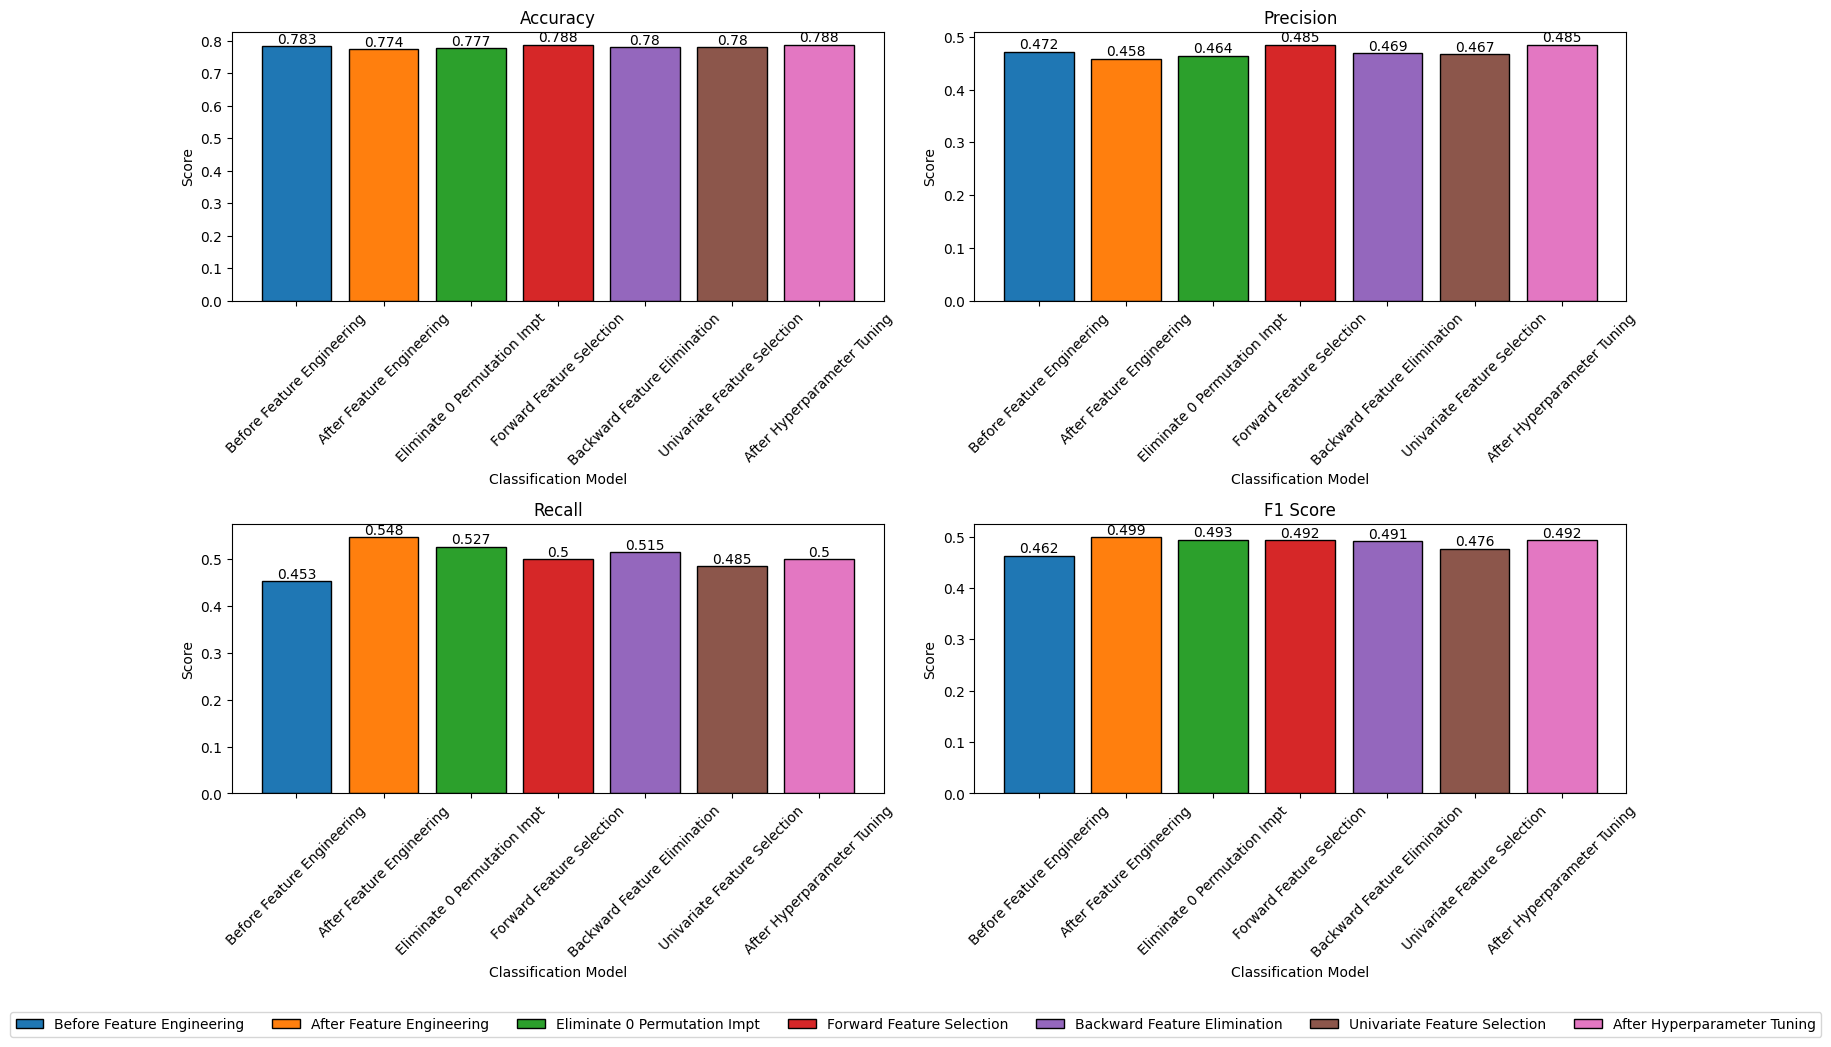

In [26]:
plotMetricsGraphComparison(test_metrics)

## Export Best Model

In [27]:
# Exporting the features used for this model
from FeatureSelectionUtils import export_final_selected_features_to_csv

export_final_selected_features_to_csv(selected_features_forward, "Best KNN")

Features exported successfully to FinalModels/Feature_Selection/Best KNN


In [28]:
# export the best model to be compared later on
import joblib

knn_final = KNeighborsClassifier(n_neighbors=5).fit(X_train[selected_features_forward], Y_train.values.ravel())
joblib.dump(knn_final, "FinalModels/BestKNN.pkl")

['FinalModels/BestKNN.pkl']

## Next Steps

Now, after doing feature selection and hyperparameter tuning, the model is exported out such that we can compare this classification model (KNN) with the best feature selection and hyperparameter tuning to other best classification models later.


## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb)
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb)
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb) 
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb) 
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb) - <b>[You Are Here Now]</b>
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb)
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb)
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)